In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, eps=1e-5,
                 theta=None):
        """
        Args:
            eps: Threshold for determining convergence.
            theta: Initial guess for theta. If None, use your own default vector.
        """
        self.theta = theta
        self.eps = eps
        
def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: a matrix.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.empty((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)
    return inputs, labels

In [3]:
ds2_train_set_path = "C:/Users/acer/Desktop/Data_Structures_And_Algorithms/ds2_train.csv"
ds2_valid_set_path = "C:/Users/acer/Desktop/Data_Structures_And_Algorithms/ds2_valid.csv"

In [4]:
x_train, y_train = load_dataset(ds2_train_set_path)
x_valid, y_valid = load_dataset(ds2_valid_set_path)

In [5]:
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """
        m, n = x.shape
        
        phi = np.sum(y) / m
        mu_0 = np.dot(x.T, 1 - y) / np.sum(1 - y)
        mu_1 = np.dot(x.T, y) / np.sum(y)

        # Reshape y to compute pairwise product with mu
        y_reshaped = np.reshape(y, (m, -1))

        # Matrix comprises mu_0 and mu_1 based on the value of y. Shape(m, n)
        mu_x = y_reshaped * mu_0 + (1 - y_reshaped) * mu_1
        
        x_centered = (x - mu_x)
        sigma = np.dot(x_centered.T, x_centered) / m
        sigma_inv = np.linalg.inv(sigma)

        # Compute theta and theta_0 according to the conclusion from part (c)
        theta = np.dot(sigma_inv, mu_1 - mu_0)
        theta_0 = 1 / 2 * mu_0 @ sigma_inv @ mu_0 - 1 / 2 * mu_1 @ sigma_inv @ mu_1 - np.log((1 - phi) / phi)
        
        self.theta = np.insert(theta, 0, theta_0)

    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """

        # Add x_0 = 1 convention to make predictions using theta^T x >= 0
        return add_intercept(x) @ self.theta >= 0

In [6]:
gda = GDA()
gda.fit(x_train, y_train)

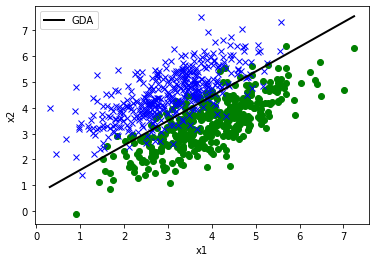

In [7]:
plt.plot(x_train[(y_train == 1), -2], x_train[(y_train == 1), -1], 'go', linewidth = 2)
plt.plot(x_train[(y_train == 0), -2], x_train[(y_train == 0), -1], 'bx', linewidth = 2)
plt.plot()

theta_2 = gda.theta

x1 = np.arange(min(x_train[:, -2]), max(x_train[:, -2]), 0.01)
x2 = -(theta_2[0] / theta_2[2] + theta_2[1] / theta_2[2] * x1)
plt.plot(x1, x2, c='black', label="GDA", linewidth=2)

# Add labels, legend and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc="upper left")

In [8]:
print("The accuracy on Training set 1 of GDA is: ", np.mean(gda.predict(x_train) == y_train))

The accuracy on Training set 1 of GDA is:  0.91375


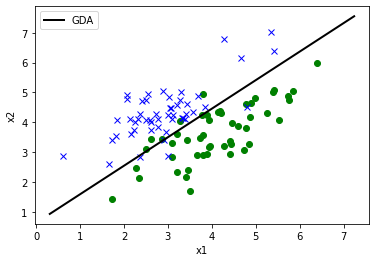

In [9]:
plt.plot(x_valid[(y_valid == 1), -2], x_valid[(y_valid == 1), -1], 'go', linewidth = 2)
plt.plot(x_valid[(y_valid == 0), -2], x_valid[(y_valid == 0), -1], 'bx', linewidth = 2)
plt.plot()

theta_2 = gda.theta

x1 = np.arange(min(x_train[:, -2]), max(x_train[:, -2]), 0.01)
x2 = -(theta_2[0] / theta_2[2] + theta_2[1] / theta_2[2] * x1)
plt.plot(x1, x2, c='black', label="GDA", linewidth=2)

# Add labels, legend and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc="upper left")

In [10]:
print("The accuracy on Validating set 1 of GDA is: ", np.mean(gda.predict(x_valid) == y_valid))

The accuracy on Validating set 1 of GDA is:  0.91
